# Some imports and functions to split the data

In [113]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

def load_spotify_data():
    return pd.read_csv(os.path.join('data', '278_labelled_uri_train.csv'))

def split_data(df):
    spotify_train, spotify_test = train_test_split(df, test_size=0.2, random_state=42)
    spotify_train_features = spotify_train.drop('labels', axis=1)
    spotify_train_label = spotify_train['labels']
    spotify_test_features = spotify_test.drop('labels', axis=1)
    spotify_test_label = spotify_test['labels']
    return spotify_train_features, spotify_train_label, spotify_test_features, spotify_test_label

def rename_labels(df):
    df.loc[df == 0] = '0 (sad)'
    df.loc[df == 1] = '1 (happy)'
    df.loc[df == 2] = '2 (energetic)'
    df.loc[df == 3] = '3 (calm)'
    return df

def eval(model, X_train, X_test, y_train, y_test):
    print('TEST')
    y_test_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.show()
    print("-------------------------------------------------------")
    print('TRAIN')
    y_train_pred = model.predict(X_train)
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    print("-------------------------------------------------------")

def drop_columns(cols_to_drop, df_train, df_val):
    df_train.drop(columns=cols_to_drop, inplace=True)
    df_val.drop(columns=cols_to_drop, inplace=True)

def correct_wrong_predicted_sets(model, X_train, y_train):
    final_predictions = model.predict(X_train)
    df = X_train.copy()
    df["label"] = y_train
    df["label_predicted"] = final_predictions
    return df[df['label'] == df['label_predicted']], df[df['label'] != df['label_predicted']]

def print_what_predicted_wrongly(label_name):
    print("predicted wrong for", label_name)
    print(incorrect[incorrect['label'] == label_name]['label_predicted'].value_counts(normalize=True))

def print_what_it_should_be(label_name):
    print(label_name, "was predicted, but should be")
    print(incorrect[incorrect['label_predicted'] == label_name]['label'].value_counts(normalize=True))

# Load the data and split it

In [103]:
X_train, y_train, X_test, y_test = split_data(load_spotify_data())
rename_labels(y_train)
rename_labels(y_test)

# columns_to_drop = ["uri", "Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2", "duration (ms)", "speechiness", "liveness", "tempo", "spec_rate"]

# drop_columns(["uri", "Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2", "duration (ms)", "speechiness", "liveness", "tempo", "spec_rate"], X_train, X_test)
drop_columns(["uri", "Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2"], X_train, X_test)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177880 entries, 199972 to 121958
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration (ms)     177880 non-null  float64
 1   danceability      177880 non-null  float64
 2   energy            177880 non-null  float64
 3   loudness          177880 non-null  float64
 4   speechiness       177880 non-null  float64
 5   acousticness      177880 non-null  float64
 6   instrumentalness  177880 non-null  float64
 7   liveness          177880 non-null  float64
 8   valence           177880 non-null  float64
 9   tempo             177880 non-null  float64
 10  spec_rate         177880 non-null  float64
dtypes: float64(11)
memory usage: 16.3 MB


# First try with a SDGClassifier

In [104]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=0.01))

clf.fit(X_train, y_train)

eval(clf, X_train, X_test, y_train, y_test)

TEST
[[ 9788  2105   394   851]
 [ 1916 14018   994   192]
 [  129  1899  5536    38]
 [  171    94    12  6333]]
               precision    recall  f1-score   support

      0 (sad)       0.82      0.75      0.78     13138
    1 (happy)       0.77      0.82      0.80     17120
2 (energetic)       0.80      0.73      0.76      7602
     3 (calm)       0.85      0.96      0.90      6610

     accuracy                           0.80     44470
    macro avg       0.81      0.81      0.81     44470
 weighted avg       0.80      0.80      0.80     44470

-------------------------------------------------------
TRAIN
[[39187  8393  1634  3234]
 [ 7085 55924  4302   694]
 [  535  7648 21778   114]
 [  681   350    54 26267]]
               precision    recall  f1-score   support

      0 (sad)       0.83      0.75      0.78     52448
    1 (happy)       0.77      0.82      0.80     68005
2 (energetic)       0.78      0.72      0.75     30075
     3 (calm)       0.87      0.96      0.91     27

In [105]:
correct, incorrect = correct_wrong_predicted_sets(clf, X_train, y_train)
incorrect

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,label,label_predicted
215967,275400.0,0.4880,0.8430,-3.393,0.0367,0.324000,0.022600,0.1070,0.6080,74.974,1.332607e-07,0 (sad),1 (happy)
127308,243413.0,0.5620,0.6710,-7.210,0.0269,0.018800,0.003780,0.0947,0.5950,106.002,1.105118e-07,0 (sad),1 (happy)
130693,268000.0,0.6260,0.5300,-6.932,0.0271,0.324000,0.000000,0.1190,0.2990,136.090,1.011194e-07,1 (happy),0 (sad)
19618,1030907.0,0.0695,0.0108,-26.729,0.0429,0.965000,0.760000,0.0777,0.0377,75.279,4.161384e-08,3 (calm),0 (sad)
67737,229440.0,0.5840,0.8500,-5.444,0.0422,0.000956,0.000049,0.3110,0.7900,130.018,1.839261e-07,2 (energetic),1 (happy)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65725,118650.0,0.8680,0.6110,-10.337,0.1210,0.026600,0.910000,0.1160,0.0913,99.987,1.019806e-06,2 (energetic),1 (happy)
2747,262347.0,0.2670,0.8540,-3.605,0.0933,0.371000,0.000000,0.0836,0.2630,80.158,3.556359e-07,2 (energetic),0 (sad)
122537,242320.0,0.0946,0.5750,-11.107,0.0502,0.093600,0.417000,0.1020,0.0710,73.821,2.071641e-07,0 (sad),2 (energetic)
84478,235569.0,0.6340,0.5930,-4.154,0.0458,0.549000,0.000017,0.1390,0.1180,93.955,1.944229e-07,1 (happy),0 (sad)


# Incorrect predictions: Show what should have been predicted instead

In [106]:
correct, incorrect = correct_wrong_predicted_sets(clf, X_train, y_train)

incorrect['label'].value_counts(normalize=True)

label
0 (sad)          0.381897
1 (happy)        0.347915
2 (energetic)    0.238941
3 (calm)         0.031246
Name: proportion, dtype: float64

# Incorrect predictions: Show what was predicted incorrectly

In [107]:
correct, incorrect = correct_wrong_predicted_sets(clf, X_train, y_train)

incorrect['label_predicted'].value_counts(normalize=True)

label_predicted
1 (happy)        0.472037
0 (sad)          0.239057
2 (energetic)    0.172503
3 (calm)         0.116404
Name: proportion, dtype: float64

# Show it a bit more detailed

In [108]:
correct, incorrect = correct_wrong_predicted_sets(clf, X_train, y_train)

print("--------------------")
print("What is the actual label, but what was predicted instead:")
print_what_predicted_wrongly('0 (sad)')
print_what_predicted_wrongly('1 (happy)')
print_what_predicted_wrongly('2 (energetic)')
print_what_predicted_wrongly('3 (calm)')


print("--------------------")
print("What was predicted, but what it should be:")
print_what_it_should_be('0 (sad)')
print_what_it_should_be('1 (happy)')
print_what_it_should_be('2 (energetic)')
print_what_it_should_be('3 (calm)')

--------------------
What is the actual label, but what was predicted instead:
predicted wrong for 0 (sad)
label_predicted
1 (happy)        0.632909
3 (calm)         0.243873
2 (energetic)    0.123218
Name: proportion, dtype: float64
predicted wrong for 1 (happy)
label_predicted
0 (sad)          0.586458
2 (energetic)    0.356096
3 (calm)         0.057446
Name: proportion, dtype: float64
predicted wrong for 2 (energetic)
label_predicted
1 (happy)    0.921779
0 (sad)      0.064481
3 (calm)     0.013740
Name: proportion, dtype: float64
predicted wrong for 3 (calm)
label_predicted
0 (sad)          0.627650
1 (happy)        0.322581
2 (energetic)    0.049770
Name: proportion, dtype: float64
--------------------
What was predicted, but what it should be:
0 (sad) was predicted, but should be
label
1 (happy)        0.853512
3 (calm)         0.082038
2 (energetic)    0.064450
Name: proportion, dtype: float64
1 (happy) was predicted, but should be
label
0 (sad)          0.512049
2 (energetic)  

# Playing around with the Kernel approximation

In [109]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
# rbf_feature = RBFSampler(gamma=1, random_state=1)
# X_features = rbf_feature.fit_transform(X_train)

clf = make_pipeline(StandardScaler(), RBFSampler(gamma=1, random_state=42), SGDClassifier(max_iter=1000, tol=0.01))

clf.fit(X_train, y_train)

eval(clf, X_train, X_test, y_train, y_test)

TEST
[[ 7880  3978   143  1137]
 [ 2870 13162   216   872]
 [ 1544  4629   877   552]
 [ 1469  1409    46  3686]]
               precision    recall  f1-score   support

      0 (sad)       0.57      0.60      0.59     13138
    1 (happy)       0.57      0.77      0.65     17120
2 (energetic)       0.68      0.12      0.20      7602
     3 (calm)       0.59      0.56      0.57      6610

     accuracy                           0.58     44470
    macro avg       0.60      0.51      0.50     44470
 weighted avg       0.59      0.58      0.54     44470

-------------------------------------------------------
TRAIN
[[31676 15732   641  4399]
 [11033 52640   986  3346]
 [ 6097 18445  3384  2149]
 [ 6044  5597   232 15479]]
               precision    recall  f1-score   support

      0 (sad)       0.58      0.60      0.59     52448
    1 (happy)       0.57      0.77      0.66     68005
2 (energetic)       0.65      0.11      0.19     30075
     3 (calm)       0.61      0.57      0.59     27

# Random forest

TEST
[[12432   496    74   136]
 [  424 16239   437    20]
 [   81   733  6785     3]
 [  131    44     3  6432]]
               precision    recall  f1-score   support

      0 (sad)       0.95      0.95      0.95     13138
    1 (happy)       0.93      0.95      0.94     17120
2 (energetic)       0.93      0.89      0.91      7602
     3 (calm)       0.98      0.97      0.97      6610

     accuracy                           0.94     44470
    macro avg       0.95      0.94      0.94     44470
 weighted avg       0.94      0.94      0.94     44470



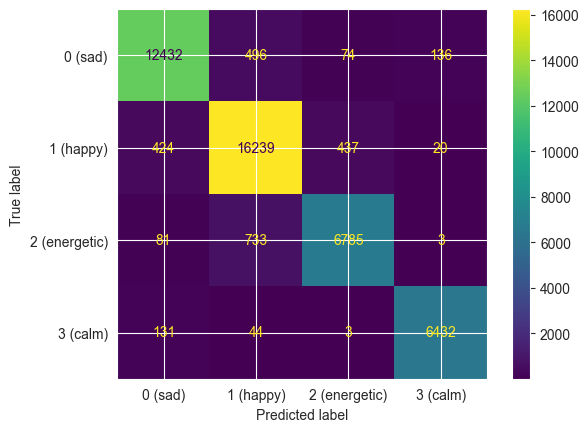

-------------------------------------------------------
TRAIN
[[52448     0     0     0]
 [    0 68005     0     0]
 [    0     1 30074     0]
 [    0     0     0 27352]]
               precision    recall  f1-score   support

      0 (sad)       1.00      1.00      1.00     52448
    1 (happy)       1.00      1.00      1.00     68005
2 (energetic)       1.00      1.00      1.00     30075
     3 (calm)       1.00      1.00      1.00     27352

     accuracy                           1.00    177880
    macro avg       1.00      1.00      1.00    177880
 weighted avg       1.00      1.00      1.00    177880

-------------------------------------------------------


In [114]:
from sklearn.ensemble import RandomForestClassifier

clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))

clf.fit(X_train, y_train)

eval(clf, X_train, X_test, y_train, y_test)

# Random forest with GridSearchCV / Hyperparameter

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3],
    'min_samples_split': [8],
    'n_estimators': [100]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 10)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
